In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Automatically generating object masks with SAM

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `SAM 2` in your environment using the installation instructions in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-do1wdm0g
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-do1wdm0g
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.1 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=sam_2-1.0-cp312-cp312-linux_x86_64.whl size=501910 sha256=2015483a5b04b06d818343a63ef797310c26be2b195422104a3a75f1b1cb0684
  Stored in directory: /tmp/pip-ephem-wheel-cache-ihd1dlco/wheels/25/a3/8a/abd69dc6a6926b5e75c248

## Set-up

In [3]:
pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 68.2 MB/s eta 0:00:00


In [7]:
!pip install torchgeo[all]

  Using cached torchgeo-0.7.2-py3-none-any.whl.metadata (18 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.2/825.2 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.0/605.0 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8

In [8]:
import rasterio

import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image


# Import TorchGeo
import torchgeo
from torchgeo.datasets import RasterDataset, VectorDataset
from torchgeo.samplers import GridGeoSampler, RandomGeoSampler

# Import SAM 2
import sam2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# Other useful imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd

# Test if they imported correctly
print("TorchGeo version:", torchgeo.__version__)
print("SAM 2 imported successfully!")
print("PyTorch version:", torch.__version__)

TorchGeo version: 0.7.2
SAM 2 imported successfully!
PyTorch version: 2.8.0+cu126


In [15]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [16]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

## Example image

In [54]:
# image = Image.open('images/cars.jpg')
# image = np.array(image.convert("RGB"))

# --- this is for fcc of the image
image = Image.open('images/2021-09-04_fcc_testclip.tif')
image = np.array(image.convert("RGB"))


# Load single-band NDWI image and convert to RGB



# # Load NDWI with rasterio to handle the raw values properly
# with rasterio.open('2021-09-04_fndwi_clip_sam.tif') as src:
#   ndwi = src.read(1)  # Read first band

# # Normalize NDWI from [-1, 1] to [0, 255] for PIL
# ndwi_normalized = ((ndwi + 1) / 2 * 255).astype(np.uint8)

# # Convert to PIL Image and then to RGB
# image = Image.fromarray(ndwi_normalized)
# image_rgb = np.array(image.convert("RGB"))


# ## ---- this is for stacking ndwi to a 3 band image
# # Load and convert NDWI
# with rasterio.open('images/2021-09-04_fndwi_clip_sam.tif') as src:
#     ndwi = src.read(1)

# # Normalize to 0-255
# ndwi_normalized = ((ndwi + 1) / 2 * 255).astype(np.uint8)

# # Create 3-channel numpy array directly
# image = np.stack([ndwi_normalized, ndwi_normalized, ndwi_normalized], axis=-1)



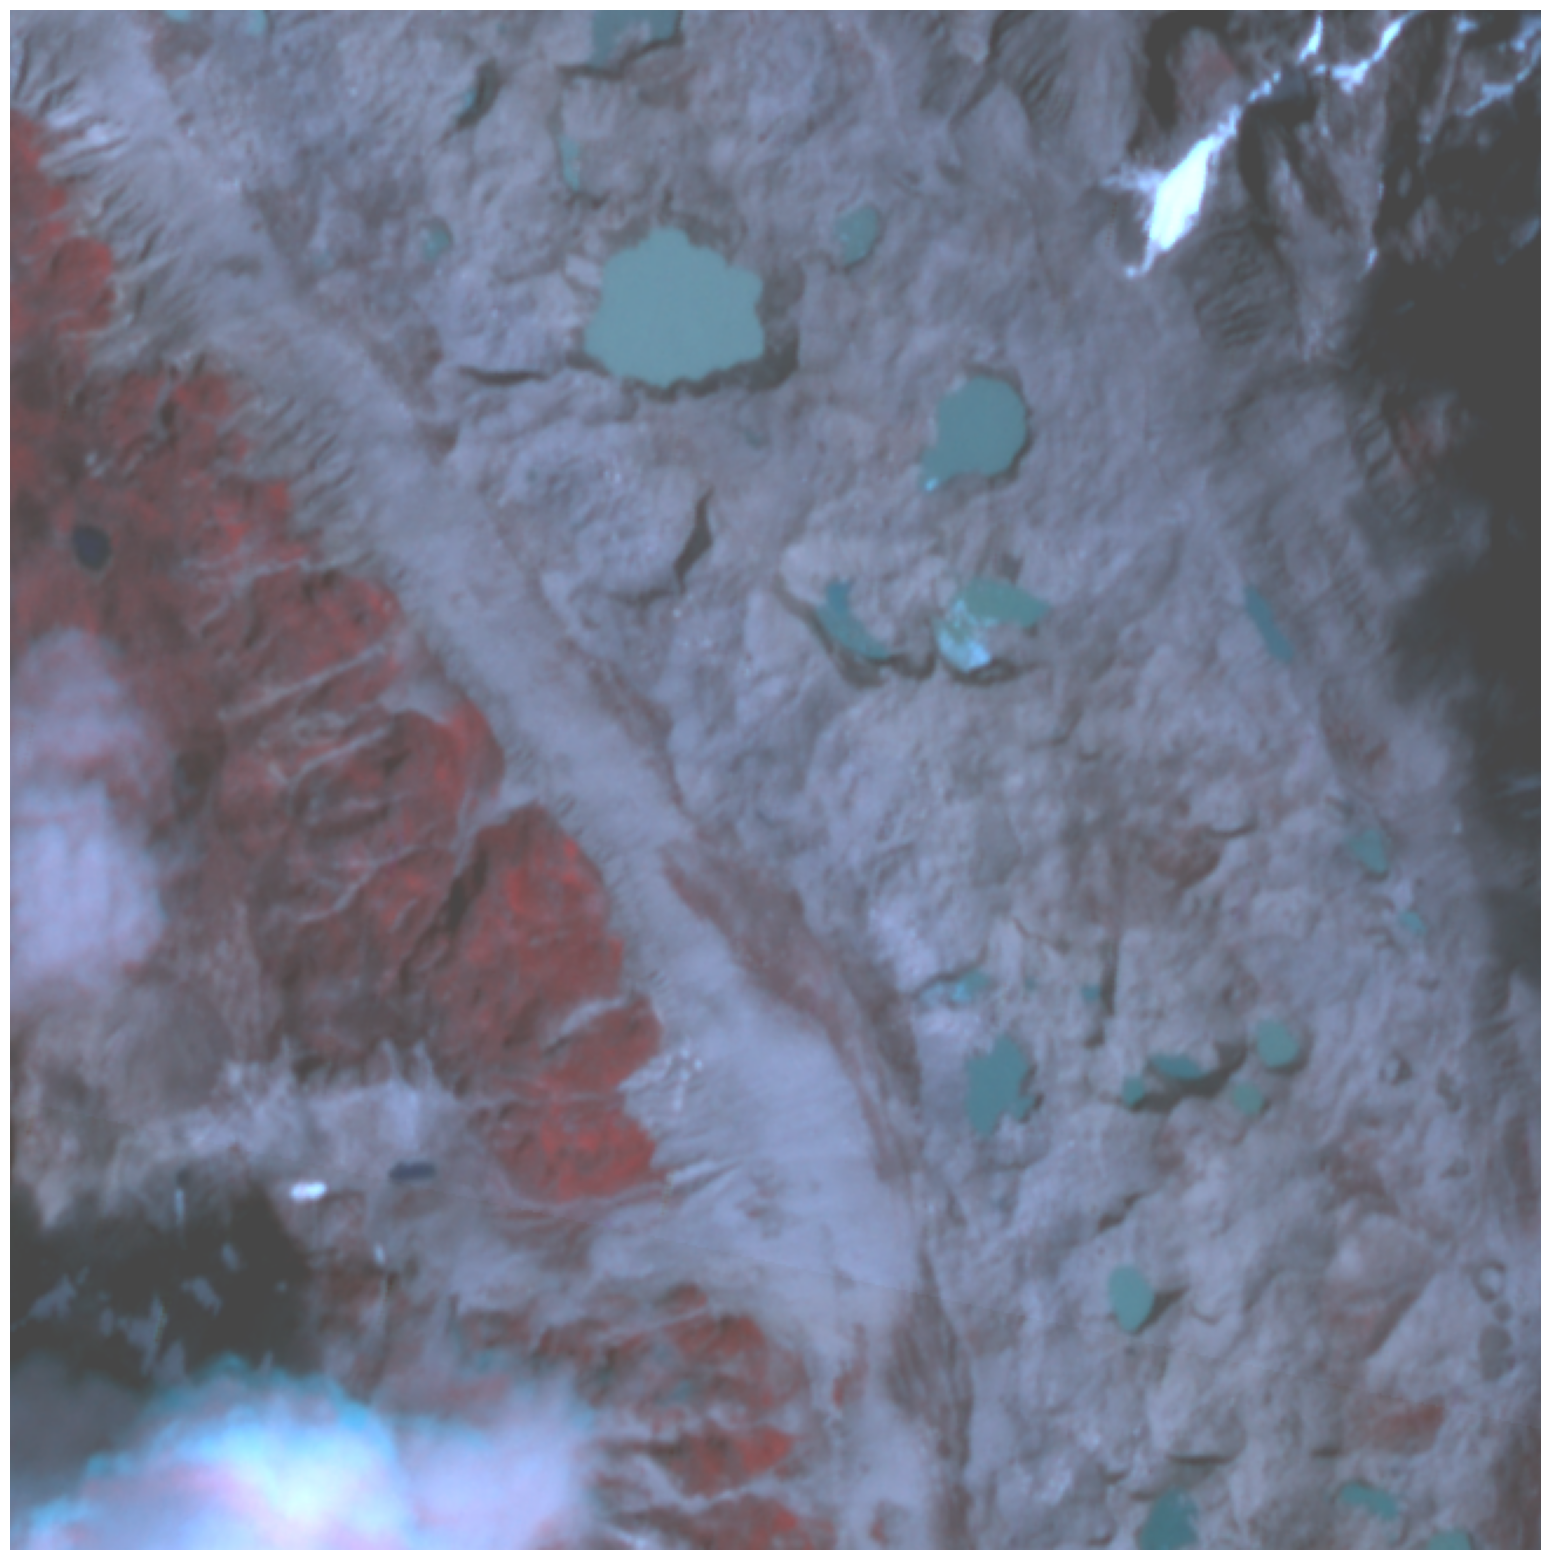

In [55]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a version of SAM 2 to the `SAM2AutomaticMaskGenerator` class. Set the path below to the SAM 2 checkpoint.

In [56]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

To generate masks, just run `generate` on an image.

In [30]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [31]:
print(len(masks))
print(masks[0].keys())

46
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

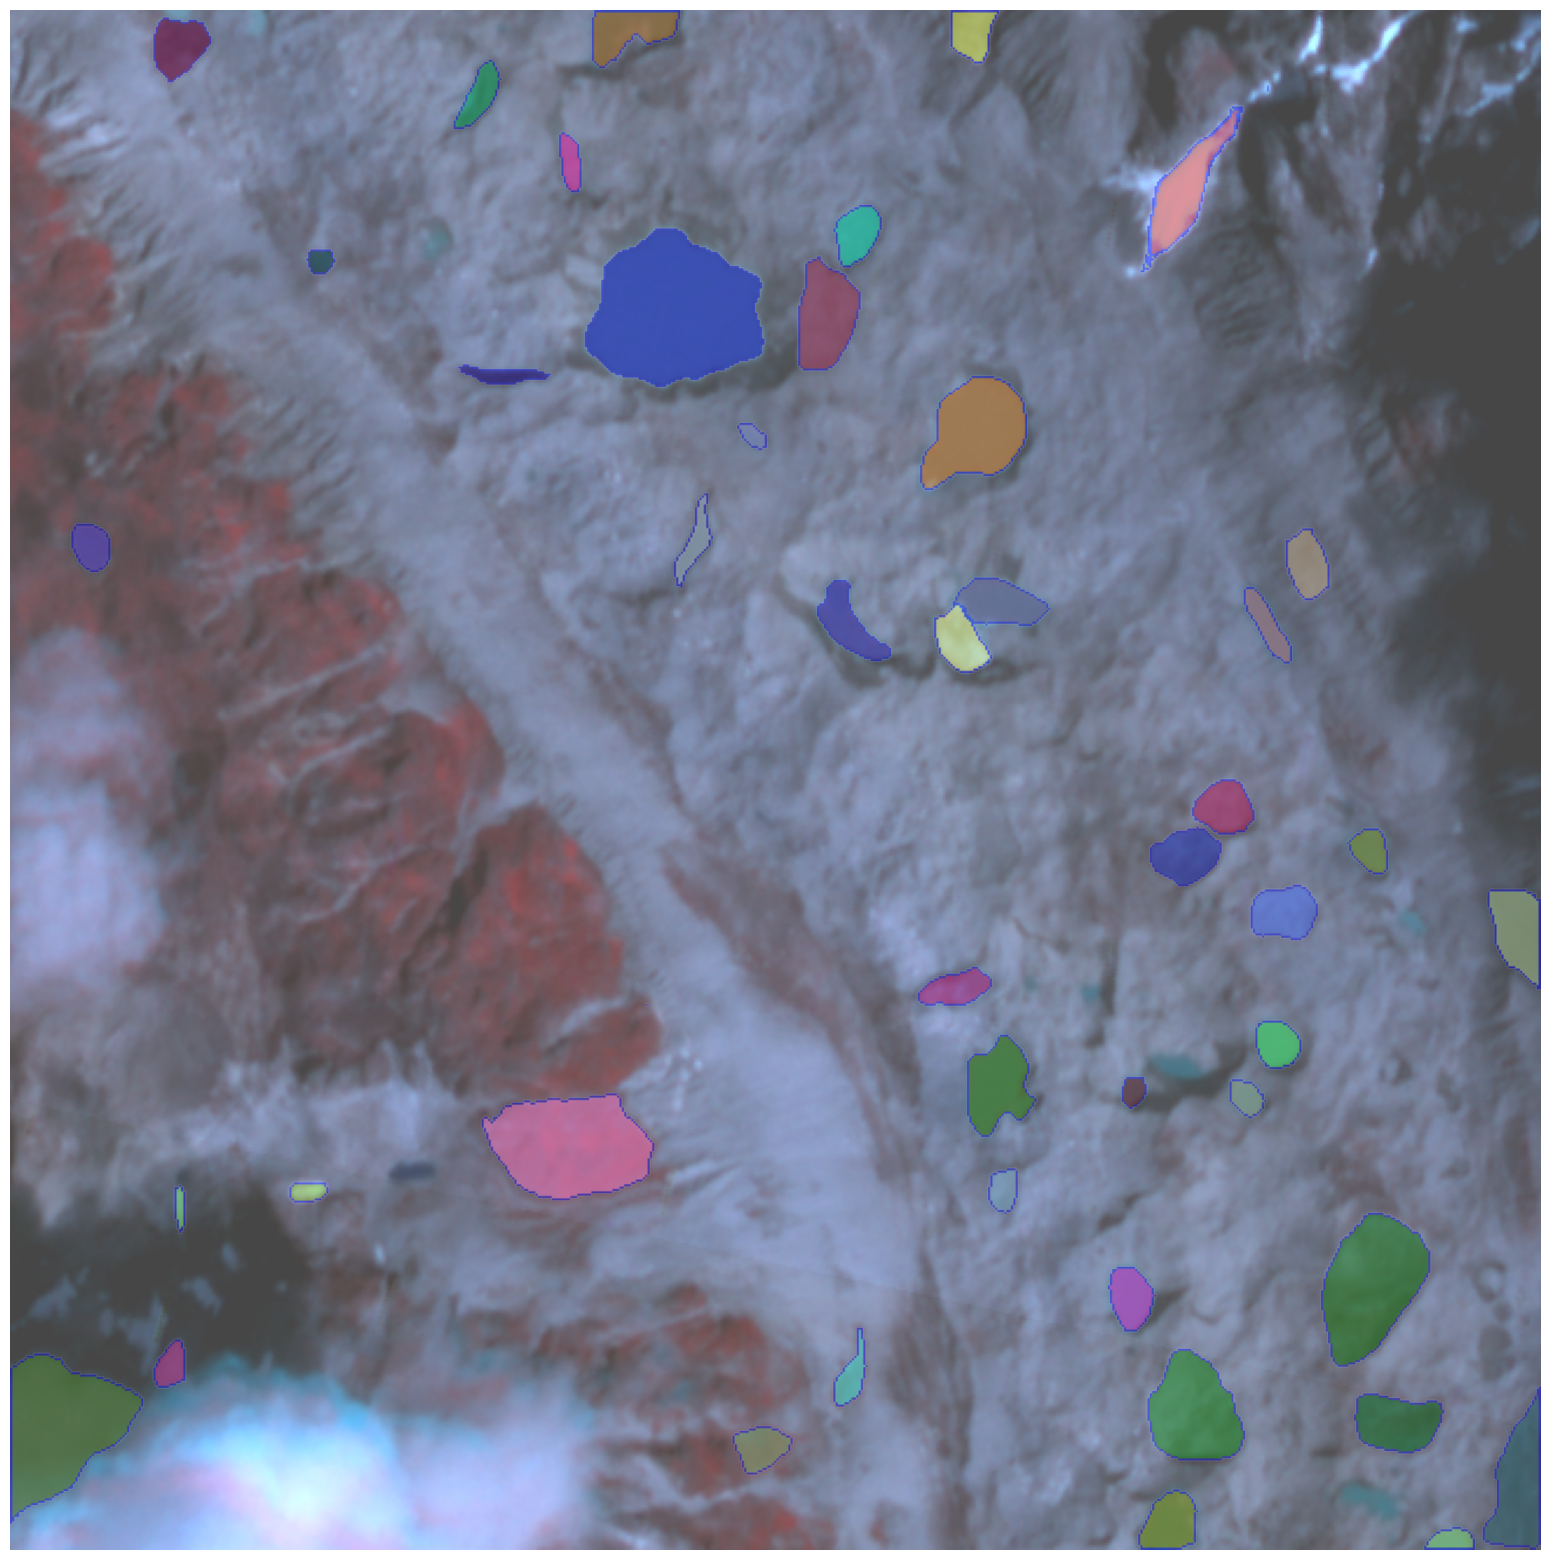

In [32]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [57]:
# mask_generator_2 = SAM2AutomaticMaskGenerator(
#     model=sam2,
#     points_per_side=64,
#     points_per_batch=128,
#     pred_iou_thresh=0.7,
#     stability_score_thresh=0.92,
#     stability_score_offset=0.7,
#     crop_n_layers=1,
#     box_nms_thresh=0.7,
#     crop_n_points_downscale_factor=2,
#     min_mask_region_area=25.0,
#     use_m2m=True,
# )


# Configuration optimized for lakes
mask_generator = SAM2AutomaticMaskGenerator(
    sam2,
    points_per_side=64,          # More dense sampling
    pred_iou_thresh=1.2,         # Slightly lower for water boundaries
    stability_score_thresh=0.9,  # Lower for irregular lake shapes
    min_mask_region_area=500,    # Remove tiny segments (adjust for lake size)
    crop_n_layers=1,             # Add one crop layer for small lakes
    crop_n_points_downscale_factor=2,
)



In [58]:
masks2 = mask_generator_2.generate(image)

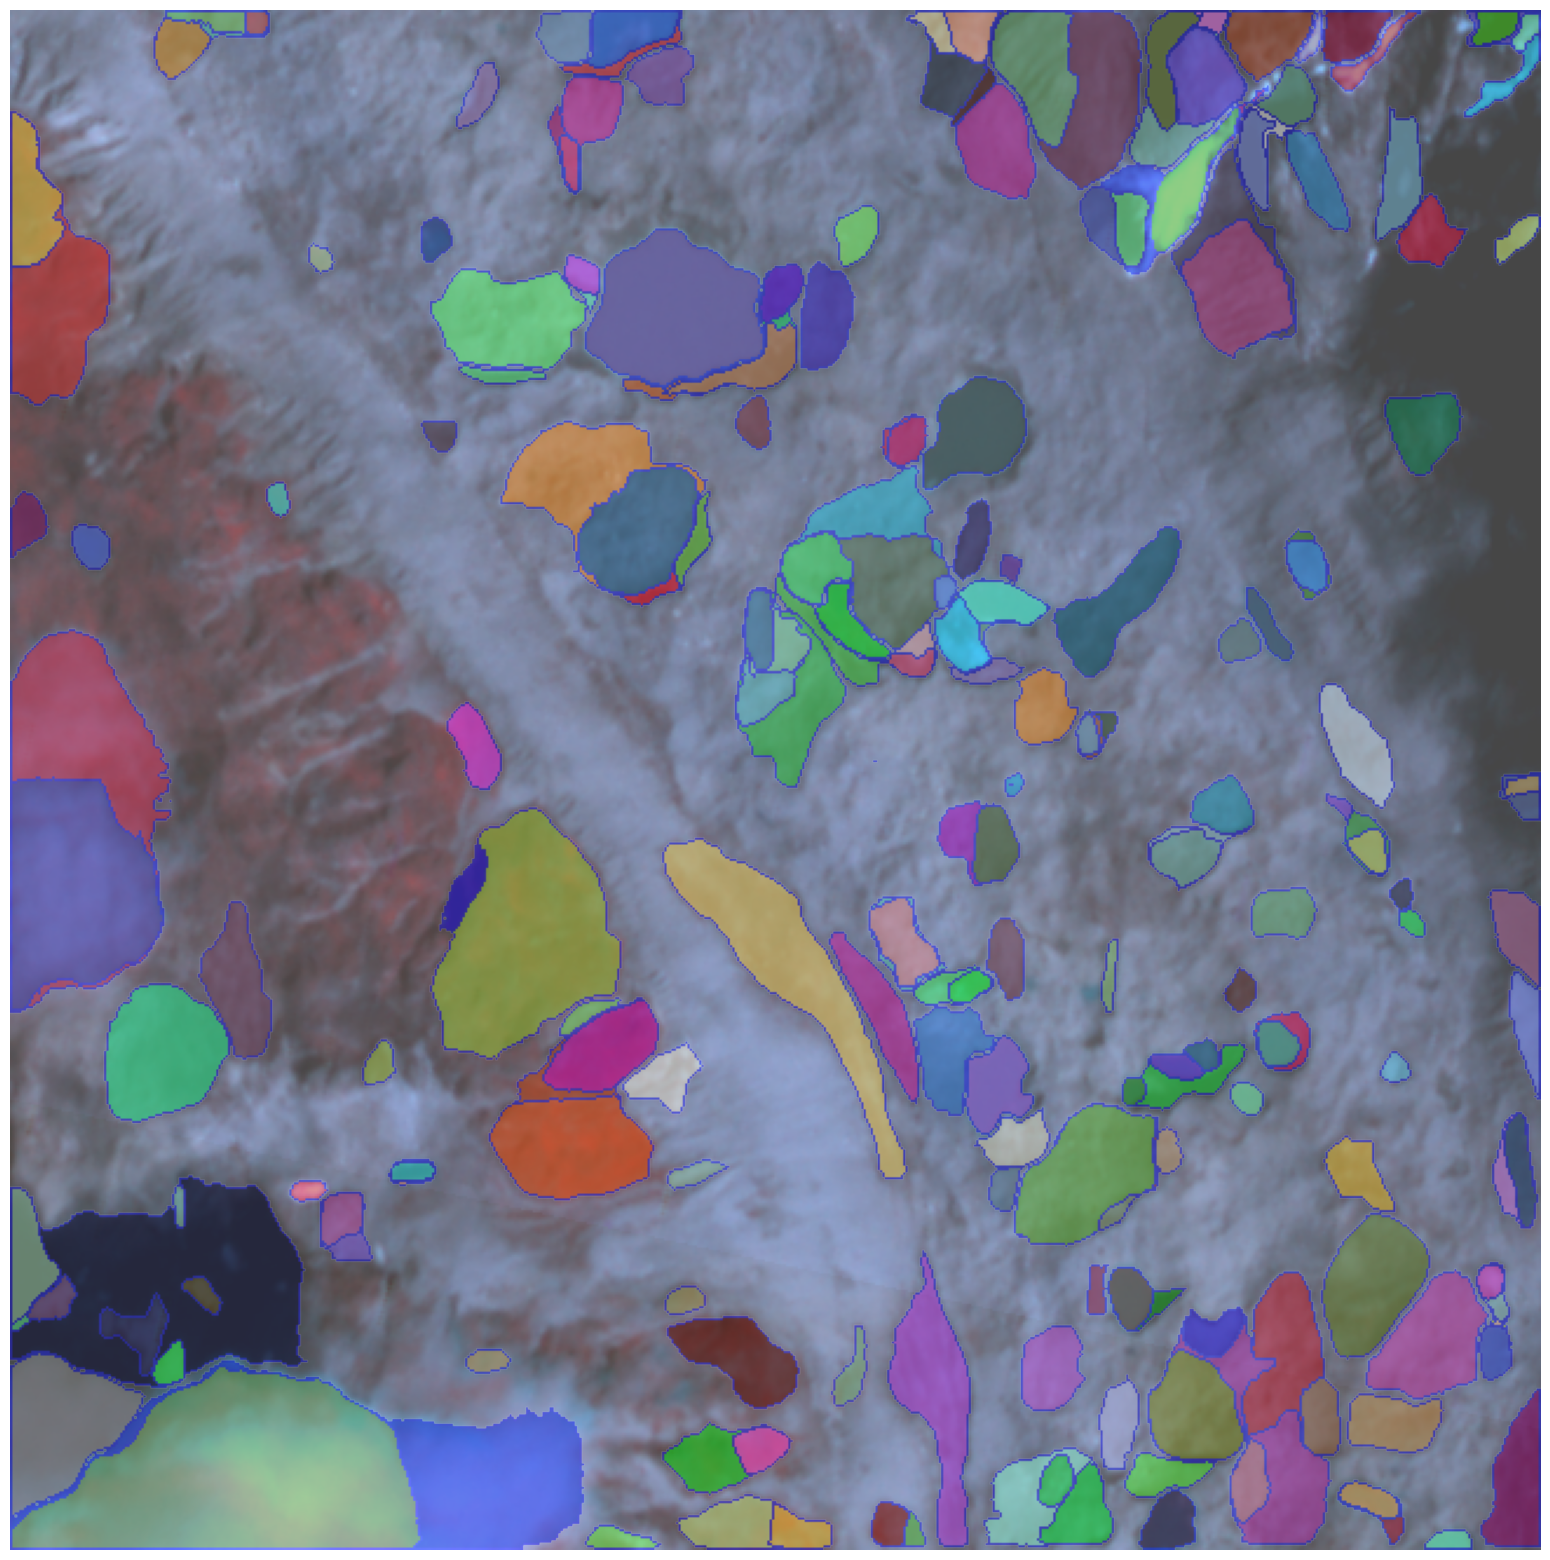

In [59]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import jaccard_score
import rasterio

# Load your ground truth raster
with rasterio.open('your_ground_truth_mask.tif') as src:
    ground_truth = src.read(1).astype(bool)  # Convert to boolean

print(f"Ground truth shape: {ground_truth.shape}")
print(f"Lake pixels: {ground_truth.sum()}")

# Define parameter combinations to test
param_configs = [
    {"points_per_side": 16, "pred_iou_thresh": 0.8, "min_mask_region_area": 100},
    {"points_per_side": 32, "pred_iou_thresh": 0.8, "min_mask_region_area": 100},
    {"points_per_side": 64, "pred_iou_thresh": 0.8, "min_mask_region_area": 100},
    {"points_per_side": 32, "pred_iou_thresh": 0.7, "min_mask_region_area": 100},
    {"points_per_side": 32, "pred_iou_thresh": 0.9, "min_mask_region_area": 100},
    {"points_per_side": 32, "pred_iou_thresh": 0.8, "min_mask_region_area": 50},
    {"points_per_side": 32, "pred_iou_thresh": 0.8, "min_mask_region_area": 500},
]

results = []

for i, config in enumerate(param_configs):
    print(f"\nTesting config {i+1}/{len(param_configs)}: {config}")

    # Create mask generator with current config
    mask_generator = SAM2AutomaticMaskGenerator(sam2, **config)

    # Generate masks
    masks = mask_generator.generate(image)

    # Combine all masks into single binary mask
    combined_mask = np.zeros_like(ground_truth, dtype=bool)
    for mask in masks:
        combined_mask |= mask['segmentation']

    # Calculate metrics
    iou = jaccard_score(ground_truth.flatten(), combined_mask.flatten())

    # Calculate precision and recall
    true_positive = (ground_truth & combined_mask).sum()
    false_positive = (~ground_truth & combined_mask).sum()
    false_negative = (ground_truth & ~combined_mask).sum()

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    # Store results
    results.append({
        'config': config,
        'iou': iou,
        'precision': precision,
        'recall': recall,
        'num_masks': len(masks)
    })

    print(f"IoU: {iou:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, Masks: {len(masks)}")

# Find best configuration
best_result = max(results, key=lambda x: x['iou'])
print(f"\n🎯 Best config: {best_result['config']}")
print(f"Best IoU: {best_result['iou']:.3f}")
print(f"Best Precision: {best_result['precision']:.3f}")
print(f"Best Recall: {best_result['recall']:.3f}")
